In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 13 17:49:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import sklearn.metrics as sk

import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Mounted at /content/drive
Found device: Tesla T4, n_gpu: 1


In [ ]:
!pip install transformers
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print('success!')

import os
import zipfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
success!


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, RobertaTokenizer, XLNetModel, XLNetTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime

def tokenize_and_format_bert(sentences, model_type):
  tokenizer = BertTokenizer.from_pretrained(model_type, do_lower_case=True)

  input_ids = []
  attention_masks = []

  for sentence in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])

  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
def tokenize_and_format_roberta(sentences, model_type):
  tokenizer = RobertaTokenizer.from_pretrained(model_type, max_length = 512)

  input_ids = []
  attention_masks = []

  for sentence in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      input_ids.append(encoded_dict['input_ids'])

      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import XLNetModel, XLNetTokenizer
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
def tokenize_and_format_xlnet(sentences, model_type):
  tokenizer = XLNetTokenizer.from_pretrained(model_type, do_lower_case=True)

  input_ids = []
  attention_masks = []

  for sentence in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

In [ ]:
def convert_to_tensors(input_ids, attention_masks):
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Project/data/final_dataset_cleaned.csv')

df = df.sample(frac=1).reset_index(drop=True)

texts = df.text.values
label = df.label.values

bert_input_ids, bert_attention_masks = tokenize_and_format_bert(texts, 'bert-base-uncased')
bert_large_input_ids, bert_large_attention_masks = tokenize_and_format_bert(texts, 'bert-large-uncased')
roberta_input_ids, roberta_attention_masks = tokenize_and_format_roberta(texts, 'roberta-base')
roberta_large_input_ids, roberta_large_attention_masks = tokenize_and_format_roberta(texts, 'roberta-large')
xlnet_input_ids, xlnet_attention_masks = tokenize_and_format_xlnet(texts, 'xlnet-base-cased')
xlnet_large_input_ids, xlnet_large_attention_masks = tokenize_and_format_xlnet(texts, 'xlnet-large-cased')

bert_input_ids, bert_attention_masks = convert_to_tensors(bert_input_ids, bert_attention_masks)

bert_large_input_ids, bert_large_attention_masks = convert_to_tensors(bert_large_input_ids, bert_large_attention_masks)

roberta_input_ids, roberta_attention_masks = convert_to_tensors(roberta_input_ids, roberta_attention_masks)

roberta_large_input_ids, roberta_large_attention_masks = convert_to_tensors(roberta_large_input_ids, roberta_large_attention_masks)

xlnet_input_ids, xlnet_attention_masks = convert_to_tensors(xlnet_input_ids, xlnet_attention_masks)

xlnet_large_input_ids, xlnet_large_attention_masks = convert_to_tensors(xlnet_large_input_ids, xlnet_large_attention_masks)

labels = torch.tensor(label)

print('Original: ', texts[0])
print('BERT Token IDs:', bert_input_ids[0])
print('BERT Large Token IDs:', bert_large_input_ids[0])
print('ROBERTA Token IDs:', roberta_input_ids[0])
print('ROBERTA Large Token IDs:', roberta_large_input_ids[0])
print('XLNET Token IDs:', xlnet_input_ids[0])
print('XLNET Large Token IDs:', xlnet_large_input_ids[0])

Original:  Where are good places to travel for a group of people, all autistic? The people from the autism group therapy program for teenagers I did a few months ago and I are considering going on a trip somewhere for a few days (we are almost all legal adults). I was wondering which places people have been to that are generally good for people with autism, so have widespread understanding of autism (in case one of us gets overstimulated or something), have a lot of things to do that consider autism, and have a lot of ways for autistic people, even tourists, to access help. None of us have high support needs, so we wouldn't need a carer, but we are all autistic and still have some support needs and so would likely need, or at the least greatly benefit from, some sort of assistance. We would go on this trip in the summer, so preferably somewhere that's not too hot would be good.
BERT Token IDs: tensor([  101,  2073,  2024,  2204,  3182,  2000,  3604,  2005,  1037,  2177,
         1997, 

In [ ]:
def train_test_val_split(num_train, num_val, num_test, total, input_ids, attention_masks, labels):
  train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train)]
  val_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train, num_val+num_train)]
  test_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_val + num_train, total)]
  return train_set, val_set, test_set

In [ ]:
total = len(df)

num_train = int(total * .8)
num_val = int(total * .1)
num_test = total - num_train - num_val

#BERT
bert_train_set, bert_val_set, bert_test_set = train_test_val_split(num_train, num_val, num_test, total, bert_input_ids, bert_attention_masks, labels)
bert_true_test_labels = [tup[2] for tup in bert_test_set]

#BERT Large
bert_large_train_set, bert_large_val_set, bert_large_test_set = train_test_val_split(num_train, num_val, num_test, total, bert_large_input_ids, bert_large_attention_masks, labels)
bert_large_true_test_labels = [tup[2] for tup in bert_test_set]

#ROBERTA
roberta_train_set, roberta_val_set, roberta_test_set = train_test_val_split(num_train, num_val, num_test, total, roberta_input_ids, roberta_attention_masks, labels)
roberta_true_test_labels = [tup[2] for tup in roberta_test_set]


#ROBERTA Large
roberta_large_train_set, roberta_large_val_set, roberta_large_test_set = train_test_val_split(num_train, num_val, num_test, total, roberta_large_input_ids, roberta_large_attention_masks, labels)
roberta_large_true_test_labels = [tup[2] for tup in roberta_large_test_set]

#XLNET 
xlnet_train_set, xlnet_val_set, xlnet_test_set = train_test_val_split(num_train, num_val, num_test, total, xlnet_input_ids, xlnet_attention_masks, labels)
xlnet_true_test_labels = [tup[2] for tup in xlnet_test_set]

#XLNET Large
xlnet_large_train_set, xlnet_large_val_set, xlnet_large_test_set = train_test_val_split(num_train, num_val, num_test, total, xlnet_large_input_ids, xlnet_large_attention_masks, labels)
xlnet_large_true_test_labels = [tup[2] for tup in xlnet_large_test_set]


train_text = [texts[i] for i in range(num_train)]
val_text = [texts[i] for i in range(num_train, num_val+num_train)]
test_text = [texts[i] for i in range(num_val + num_train, total)]

In [ ]:
def train_test_val_split2(total, input_ids, attention_masks, labels):
  test_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(total)]
  return test_set

In [ ]:
import pandas as pd 
true_test_labels = [label[i] for i in range(num_val + num_train, total)]
df = pd.DataFrame(list(zip(test_text, true_test_labels)), columns =['text', 'label']) 
print(df)
df.to_csv('/content/drive/MyDrive/Project/data/test_set.csv')
 

                                                  text  label
0    Emotional Regulation and Coping Last time I po...      4
1    My wife provides me such comfort and I don’t e...      9
2    I've changed my life and I still feel like shi...      0
3    Advice please My best friend has bipolar and I...      4
4    Have $30k in credit card debt from previous me...      9
..                                                 ...    ...
862  Don’t worry so much heart suit Your anxiety ex...      2
863  Lost in Life I’ve recently been experiencing a...      2
864  Need advice to keep living I'm sorry if my pos...      0
865  I’m done , it is to hard Everyone leaves me so...      6
866  I'm handing in my resignation on Friday I love...      4

[867 rows x 2 columns]


## BERT Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
bert_model.cuda()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import AdamW
batch_size = 16
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )
epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# BERT Large Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

bert_large_model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased", # Use the 24-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
bert_large_model.cuda()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [ ]:
from transformers import AdamW
batch_size = 16
bert_large_optimizer = AdamW(bert_large_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8  
                )
epochs = 10

# ROBERTA Model

In [ ]:
from transformers import RobertaForSequenceClassification

roberta_model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 10, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
from transformers import AdamW
batch_size = 16
roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
epochs = 10

# ROBERTA Large Model

In [ ]:
from transformers import RobertaForSequenceClassification

roberta_large_model = RobertaForSequenceClassification.from_pretrained(
    'roberta-large',
    num_labels = 10, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
roberta_large_model.cuda()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
from transformers import AdamW
batch_size = 16
roberta_large_optimizer = AdamW(roberta_large_model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8  
                )
epochs = 10

### XLNET Model

In [ ]:
from transformers import XLNetForSequenceClassification

xlnet_model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels = 10, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
xlnet_model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:
from transformers import AdamW
batch_size = 16
xlnet_optimizer = AdamW(xlnet_model.parameters(),
                  lr = 3e-5, 
                  eps = 1e-8
                )
epochs = 10

### XLNET Large Model

In [ ]:
from transformers import XLNetForSequenceClassification

xlnet_large_model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-large-cased',
    num_labels = 10, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
xlnet_large_model.cuda()

Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 1024)
    (layer): ModuleList(
      (0-23): 24 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
          (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=1024, out_features=1024, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
  

In [ ]:
from transformers import AdamW
batch_size = 16
xlnet_large_optimizer = AdamW(xlnet_large_model.parameters(),
                  lr = 3e-5, 
                  eps = 1e-8 
                )
epochs = 10

# Training And Validation Performance

In [ ]:
import numpy as np

def get_validation_performance(model, val_set, is_test_set):
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    predicted_labels = []

    num_batches = int(len(val_set)/batch_size) + 1

    total_correct = 0

    probabilities = []

    for i in range(num_batches):

      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      with torch.no_grad():        
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        if is_test_set:
          p = torch.nn.functional.softmax(logits, dim=1)
          for i in p:
            probabilities.append(i.tolist())
        
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct

        predicted_labels.extend(pred_flat)
        
    avg_val_accuracy = total_correct / len(val_set)

    return avg_val_accuracy, predicted_labels, probabilities



In [ ]:
import random
def train(model, optimizer, train_set, val_set, model_path):

  train_loss_set = []

  best_val = 0
  best_model = model

  for epoch_i in range(0, epochs):

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      total_train_loss = 0

      model.train()

      num_batches = int(len(train_set)/batch_size) + 1

      for i in range(num_batches):
        end_index = min(batch_size * (i+1), len(train_set))

        batch = train_set[i*batch_size:end_index]

        if len(batch) == 0: continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])

        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()
        train_loss_set.append(loss.item())

        loss.backward()

        optimizer.step()
          
      print(f"Total loss: {total_train_loss}")
      val_acc, predictions, _ = get_validation_performance(model, val_set, False)
      print(f"Validation accuracy: {val_acc}")
      if val_acc > best_val:
        best_val = val_acc
        best_model = model

      
  print("")
  print(f"Training complete! Saving model to: {model_path}")
  torch.save(model, model_path)
  return train_loss_set


### Training BERT

In [ ]:
#Train BERT
bert_loss_set = train(bert_model, bert_optimizer, bert_train_set, bert_val_set, "/content/drive/MyDrive/Project/models/bert_model_2.pt")


======== Epoch 1 / 10 ========
Training...
Total loss: 621.5451548695564
Validation accuracy: 0.7182448036951501

======== Epoch 2 / 10 ========
Training...
Total loss: 337.42330749332905
Validation accuracy: 0.7401847575057737

======== Epoch 3 / 10 ========
Training...
Total loss: 224.03516902774572
Validation accuracy: 0.7182448036951501

======== Epoch 4 / 10 ========
Training...
Total loss: 154.86229525879025
Validation accuracy: 0.733256351039261

======== Epoch 5 / 10 ========
Training...
Total loss: 103.4686445966363
Validation accuracy: 0.7043879907621247

======== Epoch 6 / 10 ========
Training...
Total loss: 64.31631819624454
Validation accuracy: 0.7159353348729792

======== Epoch 7 / 10 ========
Training...
Total loss: 43.74020556267351
Validation accuracy: 0.7147806004618937

======== Epoch 8 / 10 ========
Training...
Total loss: 31.212998047471046
Validation accuracy: 0.7090069284064665

======== Epoch 9 / 10 ========
Training...
Total loss: 21.836513061076403
Validation

In [ ]:
#Get train performance for BERT
accuracy_bert, predictions_bert, probabilities_bert = get_validation_performance(bert_model, bert_test_set, True)
print(accuracy_bert)

0.6955017301038062


In [ ]:
loaded_bert_model = torch.load('/content/drive/MyDrive/Project/models/bert_model_2.pt')
accuracy_bert, predictions_bert, probabilities_bert = get_validation_performance(loaded_bert_model, bert_test_set, True)
print(accuracy_bert)

0.6955017301038062


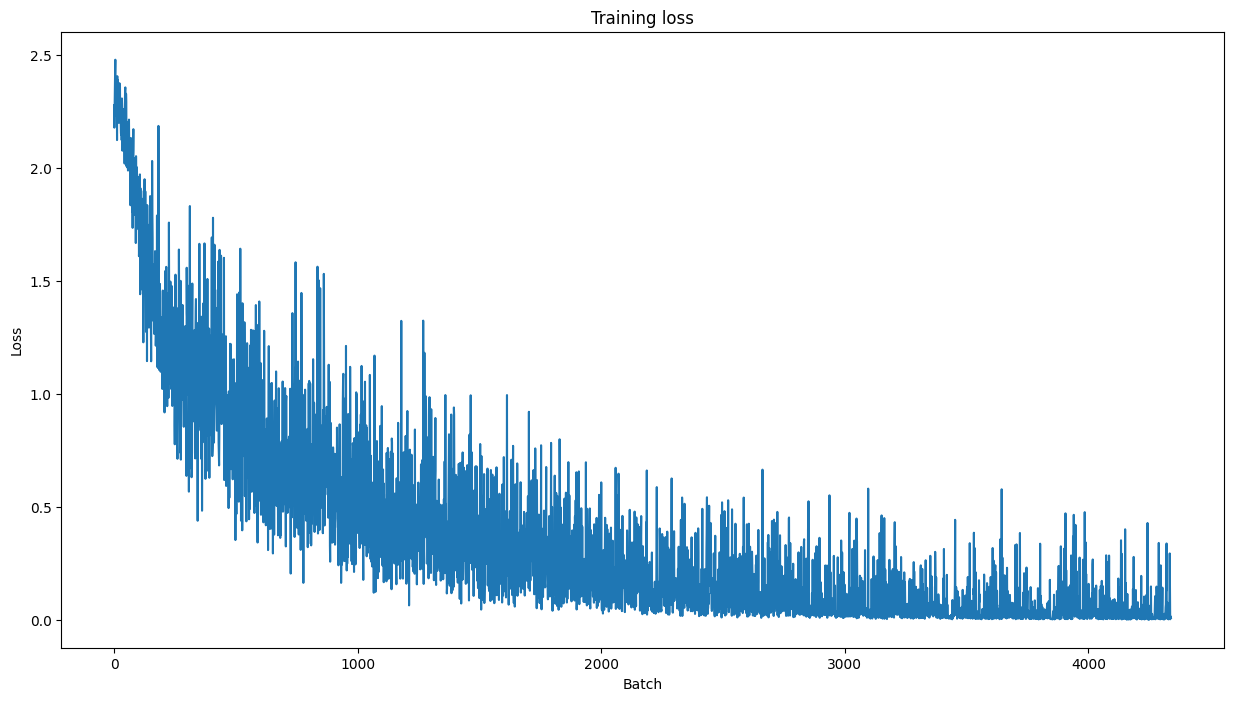

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(bert_loss_set)
plt.show()

### Training BERT Large

In [ ]:
#Train BERT Large
bert_large_loss_set = train(bert_large_model, bert_large_optimizer, bert_large_train_set, bert_large_val_set, "/content/drive/MyDrive/Project/models/bert_large_model.pt")



======== Epoch 1 / 10 ========
Training...
Total loss: 624.4596523344517
Validation accuracy: 0.6997690531177829

======== Epoch 2 / 10 ========
Training...
Total loss: 338.6774976104498
Validation accuracy: 0.7228637413394919

======== Epoch 3 / 10 ========
Training...
Total loss: 224.78193080797791
Validation accuracy: 0.7321016166281755

======== Epoch 4 / 10 ========
Training...
Total loss: 146.23278676345944
Validation accuracy: 0.7217090069284064

======== Epoch 5 / 10 ========
Training...
Total loss: 96.06931868800893
Validation accuracy: 0.7205542725173211

======== Epoch 6 / 10 ========
Training...
Total loss: 68.82135094702244
Validation accuracy: 0.7263279445727483

======== Epoch 7 / 10 ========
Training...
Total loss: 46.151939949486405
Validation accuracy: 0.7136258660508084

======== Epoch 8 / 10 ========
Training...
Total loss: 34.25746538781095
Validation accuracy: 0.7147806004618937

======== Epoch 9 / 10 ========
Training...
Total loss: 39.55749422532972
Validation 

In [ ]:
accuracy_bert_large, predictions_bert_large, probabilities_bert_large = get_validation_performance(bert_large_model, bert_large_test_set, True)
print(accuracy_bert_large)

0.6874279123414071


In [ ]:
loaded_bert_large_model = torch.load('/content/drive/MyDrive/Project/models/bert_large_model.pt')
accuracy_bert_large, predictions_bert_large, probabilities_bert_large = get_validation_performance(loaded_bert_large_model, bert_large_test_set, True)

In [ ]:
print(accuracy_bert_large)

0.6874279123414071


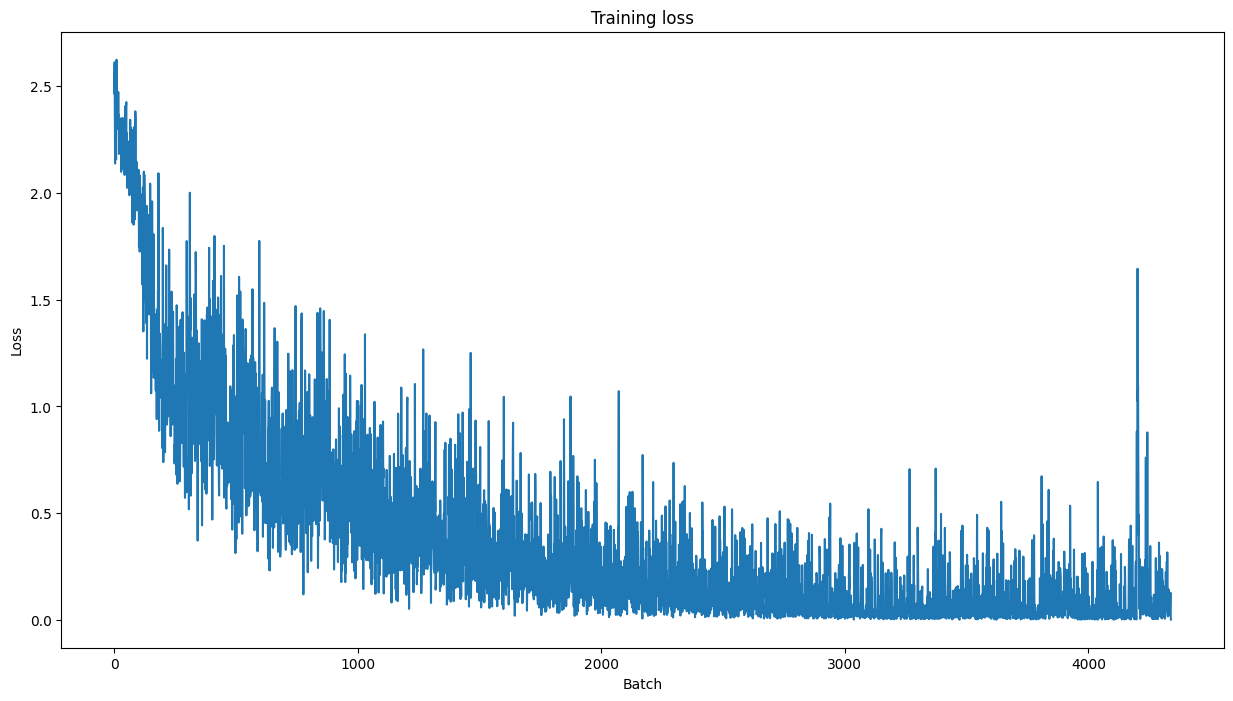

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(bert_large_loss_set)
plt.show()

### Training ROBERTA

In [ ]:
#Train RoBERTa
roberta_loss_set = train(roberta_model, roberta_optimizer, roberta_train_set, roberta_val_set, '/content/drive/MyDrive/Project/models/roberta_model.pt')


======== Epoch 1 / 10 ========
Training...
Total loss: 562.7058284580708
Validation accuracy: 0.7090069284064665

======== Epoch 2 / 10 ========
Training...
Total loss: 331.58484449982643
Validation accuracy: 0.7344110854503464

======== Epoch 3 / 10 ========
Training...
Total loss: 241.4942885413766
Validation accuracy: 0.7043879907621247

======== Epoch 4 / 10 ========
Training...
Total loss: 184.19210505485535
Validation accuracy: 0.7205542725173211

======== Epoch 5 / 10 ========
Training...
Total loss: 137.0872729830444
Validation accuracy: 0.7251732101616628

======== Epoch 6 / 10 ========
Training...
Total loss: 107.33999200537801
Validation accuracy: 0.7321016166281755

======== Epoch 7 / 10 ========
Training...
Total loss: 80.50888057611883
Validation accuracy: 0.733256351039261

======== Epoch 8 / 10 ========
Training...
Total loss: 62.14647950371727
Validation accuracy: 0.7344110854503464

======== Epoch 9 / 10 ========
Training...
Total loss: 53.93147238297388
Validation a

In [ ]:
#Get train performance for ROBERTA
accuracy_roberta, predictions_roberta, probabilities_roberta = get_validation_performance(roberta_model, roberta_test_set, True)
print(accuracy_roberta)

0.6966551326412919


In [ ]:
loaded_roberta_model = torch.load('/content/drive/MyDrive/Project/models/roberta_model.pt')
accuracy_roberta, predictions_roberta, probabilities_roberta = get_validation_performance(loaded_roberta_model, roberta_test_set, True)
print(accuracy_roberta)

0.6966551326412919


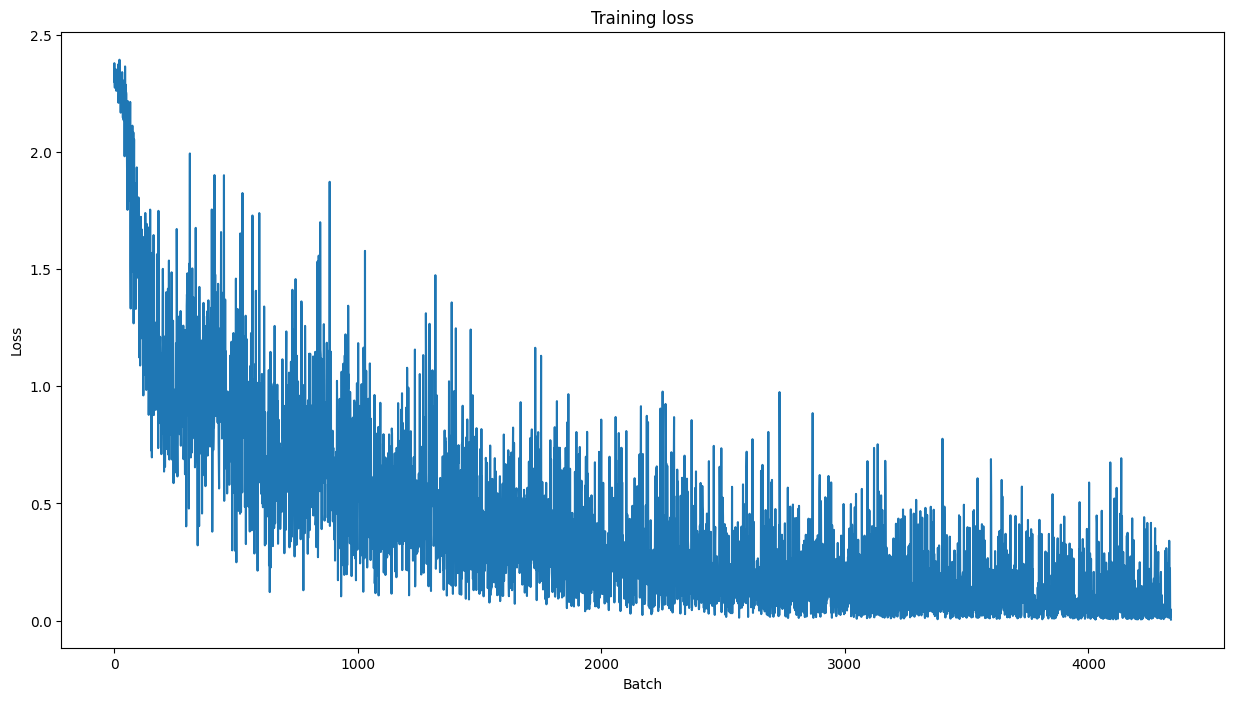

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(roberta_loss_set)
plt.show()

### Training ROBERTA Large

In [ ]:
#Train RoBERTa Large
roberta_large_loss_set = train(roberta_large_model, roberta_large_optimizer, roberta_large_train_set, roberta_large_val_set, '/content/drive/MyDrive/Project/models/roberta_large_model.pt')


======== Epoch 1 / 10 ========
Training...
Total loss: 565.8436033576727
Validation accuracy: 0.7355658198614319

======== Epoch 2 / 10 ========
Training...
Total loss: 315.7490720152855
Validation accuracy: 0.7401847575057737

======== Epoch 3 / 10 ========
Training...
Total loss: 227.967598836869
Validation accuracy: 0.7448036951501155

======== Epoch 4 / 10 ========
Training...
Total loss: 160.2647261582315
Validation accuracy: 0.7471131639722863

======== Epoch 5 / 10 ========
Training...
Total loss: 122.87631451524794
Validation accuracy: 0.7344110854503464

======== Epoch 6 / 10 ========
Training...
Total loss: 95.0395113718696
Validation accuracy: 0.7274826789838337

======== Epoch 7 / 10 ========
Training...
Total loss: 78.19129298254848
Validation accuracy: 0.7367205542725174

======== Epoch 8 / 10 ========
Training...
Total loss: 65.55071949027479
Validation accuracy: 0.7228637413394919

======== Epoch 9 / 10 ========
Training...
Total loss: 60.50057174474932
Validation accu

In [ ]:
#Get Test performance for ROBERTA Large
accuracy_roberta_large, predictions_roberta_large, probabilities_roberta_large = get_validation_performance(roberta_large_model, roberta_large_test_set, True)
print(accuracy_roberta_large)

0.7358708189158016


In [ ]:
loaded_roberta_large_model = torch.load('/content/drive/MyDrive/Project/models/roberta_large_model.pt')
accuracy_roberta_large, predictions_roberta_large, probabilities_roberta_large = get_validation_performance(loaded_roberta_large_model, roberta_large_test_set, True)
print(accuracy_roberta_large)

0.7358708189158016


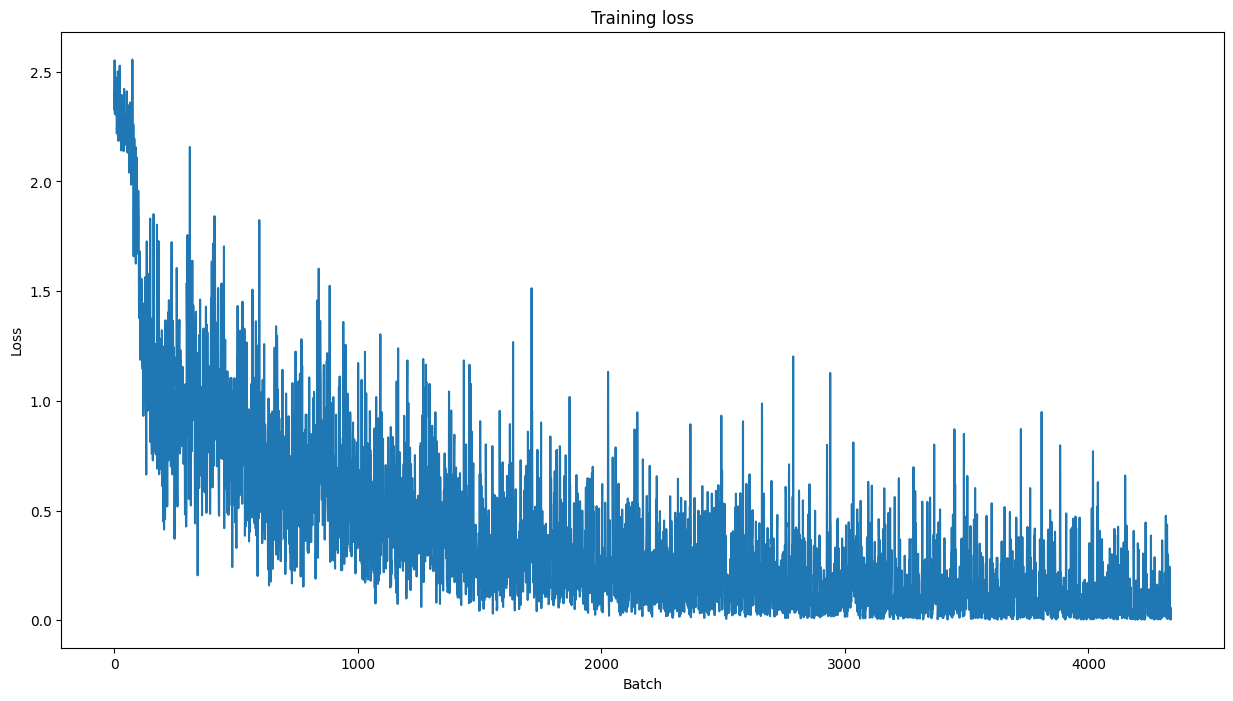

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(roberta_large_loss_set)
plt.show()

### Training XLNET

In [ ]:
#Train Xlnet
xlnet_loss_set = train(xlnet_model, xlnet_optimizer, xlnet_train_set, xlnet_val_set, '/content/drive/MyDrive/Project/models/xlnet_model.pt')


======== Epoch 1 / 10 ========
Training...
Total loss: 534.7937277555466
Validation accuracy: 0.7182448036951501

======== Epoch 2 / 10 ========
Training...
Total loss: 321.70740945637226
Validation accuracy: 0.7344110854503464

======== Epoch 3 / 10 ========
Training...
Total loss: 233.305790707469
Validation accuracy: 0.7043879907621247

======== Epoch 4 / 10 ========
Training...
Total loss: 164.75215966254473
Validation accuracy: 0.7321016166281755

======== Epoch 5 / 10 ========
Training...
Total loss: 116.4907166287303
Validation accuracy: 0.7228637413394919

======== Epoch 6 / 10 ========
Training...
Total loss: 78.65060800686479
Validation accuracy: 0.7321016166281755

======== Epoch 7 / 10 ========
Training...
Total loss: 57.88420056179166
Validation accuracy: 0.7263279445727483

======== Epoch 8 / 10 ========
Training...
Total loss: 44.82410424621776
Validation accuracy: 0.7297921478060047

======== Epoch 9 / 10 ========
Training...
Total loss: 32.349490974331275
Validation a

In [ ]:
#Get Test performance for Xlnet
accuracy_xlnet, predictions_xlnet, probabilities_xlnet = get_validation_performance(xlnet_model, xlnet_test_set, True)
print(accuracy_xlnet)

0.6897347174163783


In [ ]:
loaded_xlnet_model = torch.load('/content/drive/MyDrive/Project/models/xlnet_model.pt')
accuracy_xlnet, predictions_xlnet, probabilities_xlnet = get_validation_performance(loaded_xlnet_model, xlnet_test_set, True)
print(accuracy_xlnet)

0.6897347174163783


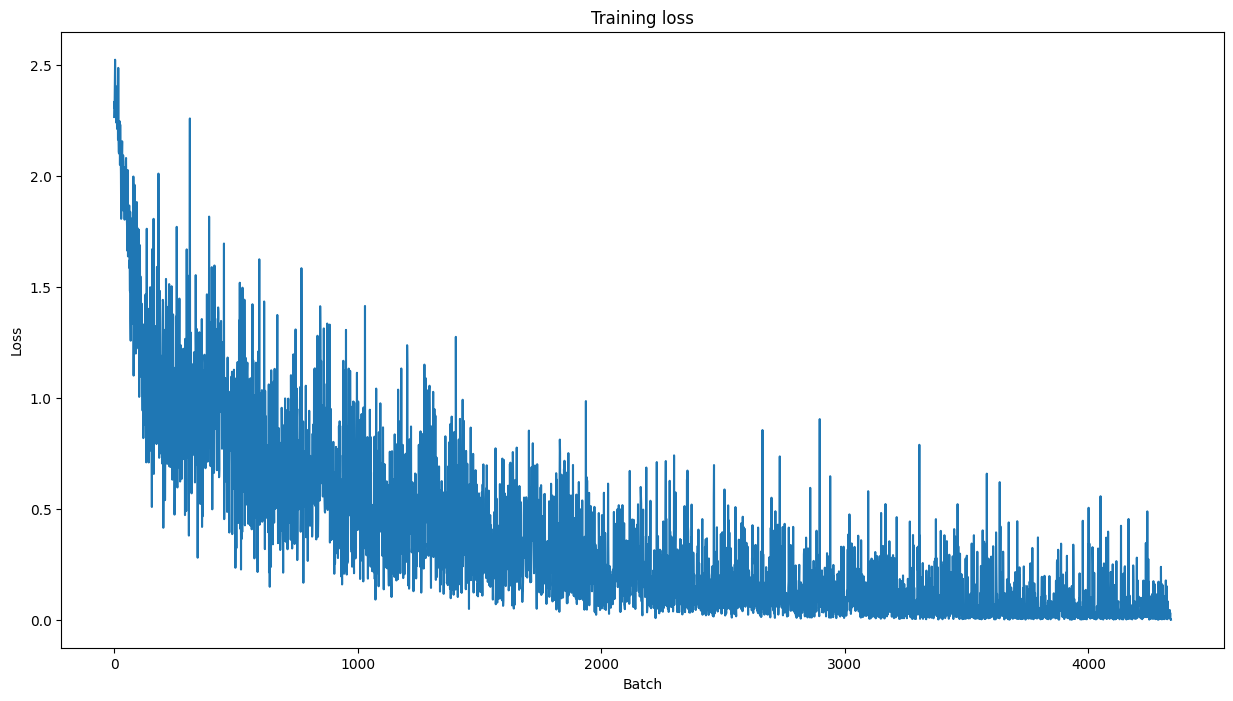

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(xlnet_loss_set)
plt.show()

### Training XLNET Large

In [ ]:
#Train Xlnet Large
xlnet_large_loss_set = train(xlnet_large_model, xlnet_large_optimizer, xlnet_large_train_set, xlnet_large_val_set, '/content/drive/MyDrive/Project/models/xlnet_large_model.pt')


======== Epoch 1 / 10 ========
Training...
Total loss: 1001.2209194898605
Validation accuracy: 0.18013856812933027

======== Epoch 2 / 10 ========
Training...
Total loss: 790.8381996452808
Validation accuracy: 0.6963048498845266

======== Epoch 3 / 10 ========
Training...
Total loss: 373.72820246219635
Validation accuracy: 0.7378752886836027

======== Epoch 4 / 10 ========
Training...
Total loss: 269.1111009567976
Validation accuracy: 0.7355658198614319

======== Epoch 5 / 10 ========
Training...
Total loss: 187.94366898201406
Validation accuracy: 0.7240184757505773

======== Epoch 6 / 10 ========
Training...
Total loss: 148.0556601844728
Validation accuracy: 0.7159353348729792

======== Epoch 7 / 10 ========
Training...
Total loss: 127.78869251720607
Validation accuracy: 0.7355658198614319

======== Epoch 8 / 10 ========
Training...
Total loss: 81.52520360914059
Validation accuracy: 0.7401847575057737

======== Epoch 9 / 10 ========
Training...
Total loss: 53.922504210611805
Validati

In [ ]:
#Get Test performance for XLNet Large
accuracy_xlnet_large, predictions_xlnet_large, probabilities_xlnet_large = get_validation_performance(xlnet_large_model, xlnet_large_test_set, True)
print(accuracy_xlnet_large)

0.7301038062283737


In [ ]:
loaded_xlnet_large_model = torch.load('/content/drive/MyDrive/Project/models/xlnet_large_model.pt')
accuracy_xlnet_large, predictions_xlnet_large, probabilities_xlnet_large = get_validation_performance(loaded_xlnet_large_model, xlnet_large_test_set, True)
print(accuracy_xlnet_large)

0.7301038062283737


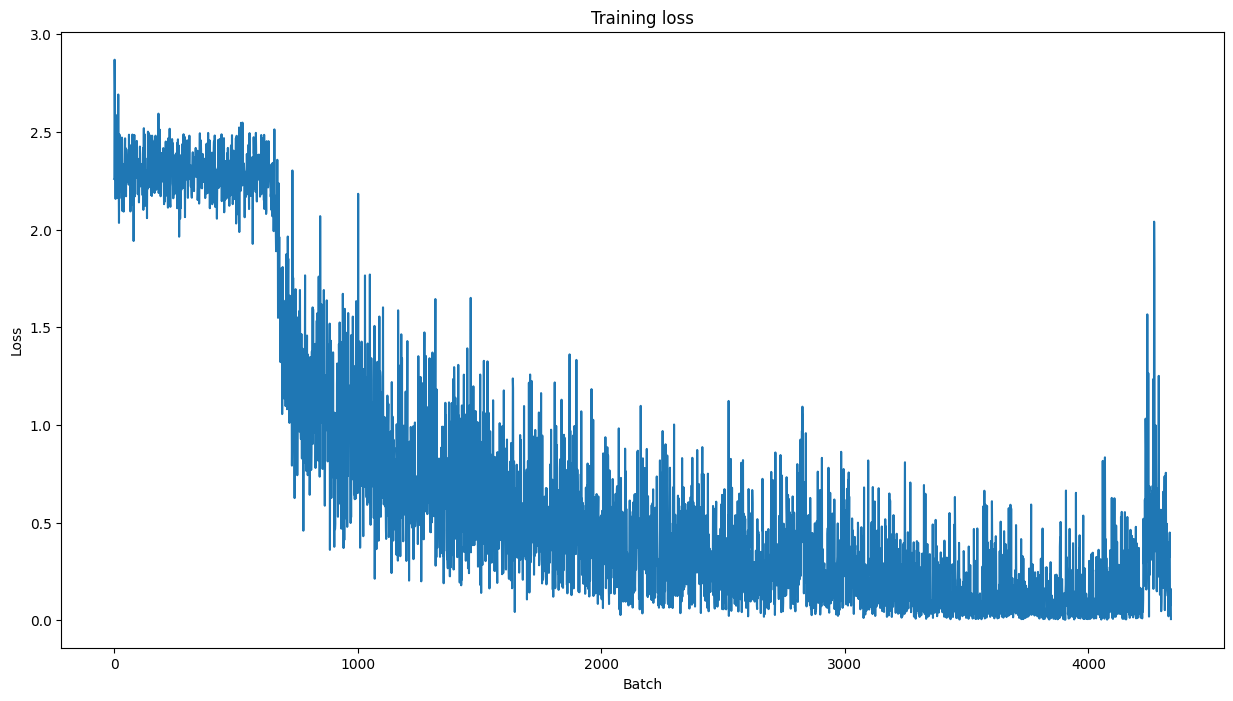

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(xlnet_large_loss_set)
plt.show()

# Ensembling

### Majority Voting Ensemble

In [ ]:
import random

def majority_voting_ensembling(model_predictions, k):
  test_data_counts_by_model = []
  
  for i in range(len(model_predictions[0])):
    current_prediction_dict = {}
  
    for idx, model_prediction in enumerate(model_predictions):
  
      if model_prediction[i] not in current_prediction_dict.keys():
        current_prediction_dict[model_prediction[i]] = 1
        continue
      current_prediction_dict[model_prediction[i]] = current_prediction_dict[model_prediction[i]] + 1 

    if k == 1:
      majority_voting_predictions = []
      cur_max_count = 0
    
      for prediction, count in current_prediction_dict.items():
    
        if len(majority_voting_predictions) == 0:
          cur_max_count = count
          majority_voting_predictions.append(prediction)
          continue
    
        if count > cur_max_count:
          majority_voting_predictions.clear()
          majority_voting_predictions.append(prediction)
          cur_max_count = count
          continue
    
        if count == cur_max_count:
          majority_voting_predictions.append(prediction)
    
      if len(majority_voting_predictions) == 1:
        test_data_counts_by_model.append(majority_voting_predictions[0])
    
      else:
        test_data_counts_by_model.append(random.choice(majority_voting_predictions))
    else:
      max = -1
      max_2 = -1
      max_label = -1
      max_label_2 = -1
      final_predictions = []
      for prediction, count in current_prediction_dict.items():
    
        if max == -1:
          max = count
          max_label = prediction
        elif count >= max:
          max_2 = max
          max_label_2 = max_label
          max = count
          max_label = prediction
        elif count < max and count > max_2:
          max_2 = count
          max_idx_2 = prediction
      test_data_counts_by_model.append([max_label, max_label_2])
  return test_data_counts_by_model

In [ ]:
def get_ensemble_accuracy(model_predictions):
    total_eval_accuracy = 0
    total_eval_loss = 0
    predicted_labels = []

    
    total_correct = 0
    for i in range(len(model_predictions)):
      if model_predictions[i] == bert_true_test_labels[i]:
        total_correct += 1 
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(model_predictions)

    return avg_val_accuracy

In [ ]:
model_predictions = [predictions_bert,
                     predictions_bert_large,
                     predictions_roberta,
                     predictions_roberta_large,
                     predictions_xlnet,
                     predictions_xlnet_large]

majority_ensemble_predictions = majority_voting_ensembling(model_predictions, 1)

In [ ]:
majority_voting_ensemble_accuracy = get_ensemble_accuracy(majority_ensemble_predictions)
print(majority_voting_ensemble_accuracy)

0.7427912341407151


### Weighted Averaging Ensemble

In [ ]:
def multiply_probabilities_by_scalar(model_probabilities, weight):
  updated_probabilities = []
  
  for model_probability_list in model_probabilities:
    updated_probabilities.append([x * weight for x in model_probability_list])
  
  return updated_probabilities

In [ ]:
import numpy as np

def weighted_averaging(model_probabilities_bert, model_probabilities_bert_large, model_probabilities_roberta, model_probabilities_roberta_large, model_probabilities_xlnet, model_probabilities_xlnet_large, eval_weights, k):
  model_probabilities_bert = multiply_probabilities_by_scalar(model_probabilities_bert, eval_weights[0])
  model_probabilities_bert_large = multiply_probabilities_by_scalar(model_probabilities_bert_large, eval_weights[1])
  model_probabilities_roberta = multiply_probabilities_by_scalar(model_probabilities_roberta, eval_weights[2])
  model_probabilities_roberta_large = multiply_probabilities_by_scalar(model_probabilities_roberta, eval_weights[3])
  model_probabilities_xlnet = multiply_probabilities_by_scalar(model_probabilities_xlnet, eval_weights[4])
  model_probabilities_xlnet_large = multiply_probabilities_by_scalar(model_probabilities_xlnet_large, eval_weights[5])
  
  final_predictions = []
  
  for prediction_idx in range(len(model_probabilities_bert)):
    data = []
    data.append(model_probabilities_bert[prediction_idx])
    data.append(model_probabilities_bert_large[prediction_idx])
    data.append(model_probabilities_roberta[prediction_idx])
    data.append(model_probabilities_roberta_large[prediction_idx])
    data.append(model_probabilities_xlnet[prediction_idx])
    data.append(model_probabilities_xlnet_large[prediction_idx])
    data = np.array(data)
    data = np.average(data, axis=0)
    best_k_classes = np.argpartition(data, -1 * k)[-1*k:]
    final_predictions.append([best_k_classes[0], best_k_classes[1]] if len(best_k_classes) > 1 else  best_k_classes[0])
    
  return final_predictions

In [ ]:
eval_weights = [accuracy_bert,
                accuracy_bert_large,
                accuracy_roberta,
                accuracy_roberta_large,
                accuracy_xlnet,
                accuracy_xlnet_large]

weighted_avg_ensemble_predictions = weighted_averaging(probabilities_bert, probabilities_bert_large, probabilities_roberta, probabilities_roberta_large, probabilities_xlnet, probabilities_xlnet_large, eval_weights, 1)

In [ ]:
weighted_avg_accuracy = get_ensemble_accuracy(weighted_avg_ensemble_predictions)
print(weighted_avg_accuracy)

0.754325259515571


# Evaluation

### Accuracy, Precision, Recall, F1 Score

In [ ]:
from tabulate import tabulate
model_list_final = ["BERT", "BERT Large", "RoBERTa", "RoBERTa Large", "XLNet", "XLNet Large", "Majority Voting Ensemble", "Weighted Avg Ensemble"]
model_accuracy_list_final = [accuracy_bert, accuracy_bert_large, accuracy_roberta, accuracy_roberta_large, accuracy_xlnet, accuracy_xlnet_large, majority_voting_ensemble_accuracy, weighted_avg_accuracy]
df = pd.DataFrame(list(zip(model_list_final, model_accuracy_list_final)), columns =['Model', 'Accuracy'])
print(tabulate(df, headers=df.columns,tablefmt='fancy_grid'))


╒════╤══════════════════════════╤════════════╕
│    │ Model                    │   Accuracy │
╞════╪══════════════════════════╪════════════╡
│  0 │ BERT                     │   0.695502 │
├────┼──────────────────────────┼────────────┤
│  1 │ BERT Large               │   0.687428 │
├────┼──────────────────────────┼────────────┤
│  2 │ RoBERTa                  │   0.696655 │
├────┼──────────────────────────┼────────────┤
│  3 │ RoBERTa Large            │   0.735871 │
├────┼──────────────────────────┼────────────┤
│  4 │ XLNet                    │   0.689735 │
├────┼──────────────────────────┼────────────┤
│  5 │ XLNet Large              │   0.730104 │
├────┼──────────────────────────┼────────────┤
│  6 │ Majority Voting Ensemble │   0.747405 │
├────┼──────────────────────────┼────────────┤
│  7 │ Weighted Avg Ensemble    │   0.754325 │
╘════╧══════════════════════════╧════════════╛


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_models(true_labels, predicted_labels):
  precision = precision_score(true_labels, predicted_labels, average="weighted")
  recall = recall_score(true_labels, predicted_labels, average='weighted')
  f1 = f1_score(true_labels, predicted_labels, average='weighted')

  return precision, recall, f1

In [ ]:
precision_bert, recall_bert, f1_bert = evaluate_models(bert_true_test_labels, predictions_bert)
precision_bert_large, recall_bert_large, f1_bert_large = evaluate_models(bert_large_true_test_labels, predictions_bert_large)
precision_roberta, recall_roberta, f1_roberta = evaluate_models(roberta_true_test_labels, predictions_roberta)
precision_roberta_large, recall_roberta_large, f1_roberta_large = evaluate_models(roberta_large_true_test_labels, predictions_roberta_large)
precision_xlnet, recall_xlnet, f1_xlnet = evaluate_models(xlnet_true_test_labels, predictions_xlnet)
precision_xlnet_large, recall_xlnet_large, f1_xlnet_large = evaluate_models(xlnet_large_true_test_labels, predictions_xlnet_large)
precision_majority_ensemble, recall_majority_ensemble, f1_majority_ensemble = evaluate_models(bert_true_test_labels, majority_ensemble_predictions)
precision_weighted_avg_ensemble, recall_weighted_avg_ensemble, f1_weighted_avg_ensemble = evaluate_models(bert_true_test_labels, weighted_avg_ensemble_predictions)

precision_list = [precision_bert, precision_bert_large, precision_roberta, precision_roberta_large, precision_xlnet, precision_xlnet_large, precision_majority_ensemble, precision_weighted_avg_ensemble]
recall_list = [recall_bert, recall_bert_large, recall_roberta, recall_roberta_large, recall_xlnet, recall_xlnet_large, recall_majority_ensemble, recall_weighted_avg_ensemble]
f1_list = [f1_bert, f1_bert_large, f1_roberta, f1_roberta_large, f1_xlnet, f1_xlnet_large, f1_majority_ensemble, f1_weighted_avg_ensemble]

df = pd.DataFrame(list(zip(model_list_final, model_accuracy_list_final, precision_list, recall_list, f1_list)), columns =['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(tabulate(df, headers=df.columns,tablefmt='fancy_grid'))

╒════╤══════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│    │ Model                    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════╪══════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│  0 │ BERT                     │   0.695502 │    0.719848 │ 0.695502 │   0.693833 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  1 │ BERT Large               │   0.687428 │    0.689699 │ 0.687428 │   0.68523  │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  2 │ RoBERTa                  │   0.696655 │    0.712146 │ 0.696655 │   0.694111 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  3 │ RoBERTa Large            │   0.735871 │    0.737684 │ 0.735871 │   0.732811 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  4 │ XLNet                    │   0.689735 │    0.703274 │ 0.68

In [ ]:
true_test_labels = [label[i] for i in range(num_val + num_train, total)]
df = pd.DataFrame(list(zip(test_text, true_test_labels, predictions_bert, predictions_bert_large, predictions_roberta, predictions_roberta_large, predictions_xlnet, predictions_xlnet_large, majority_ensemble_predictions, weighted_avg_ensemble_predictions)), columns =['text', 'true_label', 'bert_prediction', 'bert_large_prediction', 'roberta_prediction', 'roberta_large_prediction', 'xlnet_prediction', 'xlnet_large_prediction', 'majority_voting_prediction', 'weighted_avg_prediction']) 
df.to_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')


### Top k accuracy with k = 2

In [ ]:
import numpy as np

def top_2_accuracy(model_probabilities, is_ensemble, ensemble_predictions):
  total_correct = 0
  if not is_ensemble:
    final_predictions = []
    
    for prediction_idx in range(len(model_probabilities)):
      max = -1
      max_2 = -1
      max_idx = -1
      max_idx_2 = -1
      
      for i in range(len(model_probabilities[prediction_idx])):
        if max == -1:
          max = model_probabilities[prediction_idx][i]
          max_idx = i
        elif model_probabilities[prediction_idx][i] >= max:
          max_2 = max
          max_idx_2 = max_idx
          max = model_probabilities[prediction_idx][i]
          max_idx = i
        elif model_probabilities[prediction_idx][i] < max and model_probabilities[prediction_idx][i] > max_2:
          max_2 = model_probabilities[prediction_idx][i]
          max_idx_2 = i
      final_predictions.append([max_idx, max_idx_2])
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    predicted_labels = []
    for i in range(len(final_predictions)):
      if bert_true_test_labels[i] in final_predictions[i]:
        total_correct += 1 
          
    top_2_accuracy = total_correct / len(bert_true_test_labels)
    return top_2_accuracy

  else:
    for i in range(len(ensemble_predictions)):
      if bert_true_test_labels[i] in ensemble_predictions[i]:
        total_correct += 1 
          
    top_2_accuracy = total_correct / len(bert_true_test_labels)
    return top_2_accuracy

In [ ]:
top_2_accuracy_bert = top_2_accuracy(probabilities_bert, False, _)
top_2_accuracy_bert_large = top_2_accuracy(probabilities_roberta, False, _)
top_2_accuracy_roberta = top_2_accuracy(probabilities_roberta, False, _)
top_2_accuracy_roberta_large = top_2_accuracy(probabilities_roberta_large, False, _)
top_2_accuracy_xlnet = top_2_accuracy(probabilities_xlnet, False, _)
top_2_accuracy_xlnet_large = top_2_accuracy(probabilities_xlnet_large, False, _)
top_2_accuracy_majority_voting = top_2_accuracy(probabilities_bert, True, majority_voting_ensembling(model_predictions, 2))
top_2_accuracy_weighted_avg = top_2_accuracy(probabilities_roberta, True, weighted_averaging(probabilities_bert, probabilities_bert_large, probabilities_roberta, probabilities_roberta_large, probabilities_xlnet, probabilities_xlnet_large, eval_weights, 2))

In [ ]:
top_2_accuracy_list = [top_2_accuracy_bert, top_2_accuracy_bert_large, top_2_accuracy_roberta, top_2_accuracy_roberta_large, top_2_accuracy_xlnet, top_2_accuracy_xlnet_large, top_2_accuracy_majority_voting, top_2_accuracy_weighted_avg]
df = pd.DataFrame(list(zip(model_list_final, top_2_accuracy_list)), columns =['Model', 'Top 2 Accuracy'])
print(tabulate(df, headers=df.columns,tablefmt='fancy_grid'))

╒════╤══════════════════════════╤══════════════════╕
│    │ Model                    │   Top 2 Accuracy │
╞════╪══════════════════════════╪══════════════════╡
│  0 │ BERT                     │         0.838524 │
├────┼──────────────────────────┼──────────────────┤
│  1 │ BERT Large               │         0.845444 │
├────┼──────────────────────────┼──────────────────┤
│  2 │ RoBERTa                  │         0.845444 │
├────┼──────────────────────────┼──────────────────┤
│  3 │ RoBERTa Large            │         0.854671 │
├────┼──────────────────────────┼──────────────────┤
│  4 │ XLNet                    │         0.835063 │
├────┼──────────────────────────┼──────────────────┤
│  5 │ XLNet Large              │         0.847751 │
├────┼──────────────────────────┼──────────────────┤
│  6 │ Majority Voting Ensemble │         0.797001 │
├────┼──────────────────────────┼──────────────────┤
│  7 │ Weighted Avg Ensemble    │         0.874279 │
╘════╧══════════════════════════╧═════════════